In [1]:
import numpy as np
import librosa
import os
import librosa
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
from scipy.fftpack import dct
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
def extract_mfcc(
    audio_file_path,
    sample_rate=None,
    pre_emphasis=0.97,
    frame_size=0.025,
    frame_stride=0.01,
    NFFT=512,
    nfilt=40, 
    num_ceps=12,
    fixed_length=100
):
    y, sr = librosa.load(audio_file_path, sr=sample_rate)
    emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    frames *= np.hamming(frame_length)
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

    if mfcc.shape[0] < fixed_length:
        pad_width = fixed_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:fixed_length]

    return mfcc

In [3]:
def extract_mfcc_for_folders(data_folder, subfolders, **kwargs):
    features = []
    labels = []

    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_folder, subfolder)
        files = os.listdir(folder_path)
        for filename in tqdm(files, desc=f"Processing {subfolder}", unit="file"):
            if filename.endswith('.wav'):
                file_path = os.path.join(folder_path, filename)
                mfccs = extract_mfcc(file_path, **kwargs)
                features.append(mfccs.flatten().tolist())
                labels.append(label)

    return features, labels


In [4]:
data_folder = "augmentaudiocry"
# data_folder = 'clean_audio'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

features, labels = extract_mfcc_for_folders(data_folder, subfolders, fixed_length=100)

df = pd.DataFrame(features)
df['label'] = labels
df.to_csv('mfcc_features.csv', index=False)

Processing tired: 100%|██████████| 27/27 [00:00<00:00, 69.92file/s]


In [5]:
data = pd.read_csv("mfcc_features.csv")
data

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,label
0,-159.315651,-26.375534,-28.578573,-8.433506,-3.806472,-9.115132,-7.416045,-10.544687,-9.569842,-2.702649,...,-31.703410,-29.939062,-12.316477,-8.915270,-4.272530,-1.800050,-7.941504,-7.640768,-14.605054,0
1,-155.319266,-24.461046,-20.402042,2.045501,2.549556,-5.032678,-6.339676,-4.635773,-7.600740,-3.963800,...,-37.872051,-28.781557,-23.367763,-14.893004,13.695580,0.500754,-17.862365,-10.638510,8.947092,0
2,-166.417516,-25.137238,-30.027905,-25.197827,-26.156043,-13.667665,3.436556,0.829689,0.502164,-11.413344,...,-17.485404,-21.328674,-2.188615,-11.538437,-10.346101,-2.666874,-3.834681,-1.241314,0.303588,0
3,-165.757552,-37.471146,-30.579659,-5.817500,-11.255677,-3.826214,1.958919,-13.686550,-14.181264,-11.399342,...,-1.705312,-9.863075,-6.918583,-4.167622,-1.055703,1.635261,-6.367842,-3.081901,-16.396802,0
4,-157.892278,-32.356025,-35.300916,1.831975,1.044280,-12.750792,-14.721320,0.584149,-0.565884,-7.179750,...,16.194427,-27.018687,-25.457951,25.428905,30.307649,-4.273949,-15.842481,2.018398,5.373289,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-77.641844,-61.394930,-32.352352,5.635229,-34.841464,6.440827,-14.339528,-10.869606,4.882250,-18.098718,...,55.408861,-46.574877,-35.860986,7.133182,-7.844852,-4.498356,2.168922,-9.220534,-10.228052,4
131,-77.641844,-61.394930,-32.352352,5.635229,-34.841464,6.440827,-14.339528,-10.869606,4.882250,-18.098718,...,41.198871,-40.855874,-0.460195,7.713727,-18.050435,1.432830,-2.584345,-20.874871,-10.178392,4
132,-49.685014,-64.658584,-14.266036,16.029028,-32.925505,-15.786345,12.591456,-13.719700,-13.779229,6.376791,...,22.285510,-38.958108,2.857573,44.633845,-4.331254,-11.746571,13.707905,-3.273154,3.371948,4
133,129.097529,-81.734037,-102.996324,-52.513349,-34.905233,-2.338916,11.124651,-17.103032,3.694313,23.787409,...,13.104767,-5.700430,31.901521,-3.655251,-34.994450,21.511016,14.362749,-31.909532,-13.552796,4


In [6]:
X = data.drop(columns=['label'])
y = data['label']

In [7]:
y

0      0
1      0
2      0
3      0
4      0
      ..
130    4
131    4
132    4
133    4
134    4
Name: label, Length: 135, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=62)

In [9]:
forest_model = RandomForestClassifier(
    n_estimators=200,
    random_state=50,
    criterion="entropy",
    max_depth=32
)
forest_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=32, n_estimators=200,
                       random_state=50)

In [10]:
forest_predictions = forest_model.predict(X_test)
print('Random Forest Classifier Performance:')
print(classification_report(y_test, forest_predictions))

Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         6
           4       0.67      1.00      0.80         2

    accuracy                           0.90        21
   macro avg       0.90      0.87      0.84        21
weighted avg       0.93      0.90      0.89        21



In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, forest_predictions))

Accuracy: 0.9047619047619048


In [12]:
print("Classification Report:")
print(classification_report(y_test, forest_predictions))

print("Accuracy Score:")
print(accuracy_score(y_test, forest_predictions))

conf_matrix = confusion_matrix(y_test, forest_predictions)
print("\nConfusion Matrix:\n", conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         6
           4       0.67      1.00      0.80         2

    accuracy                           0.90        21
   macro avg       0.90      0.87      0.84        21
weighted avg       0.93      0.90      0.89        21

Accuracy Score:
0.9047619047619048

Confusion Matrix:
 [[4 0 0 0 0]
 [0 6 0 0 0]
 [0 1 1 0 1]
 [0 0 0 6 0]
 [0 0 0 0 2]]


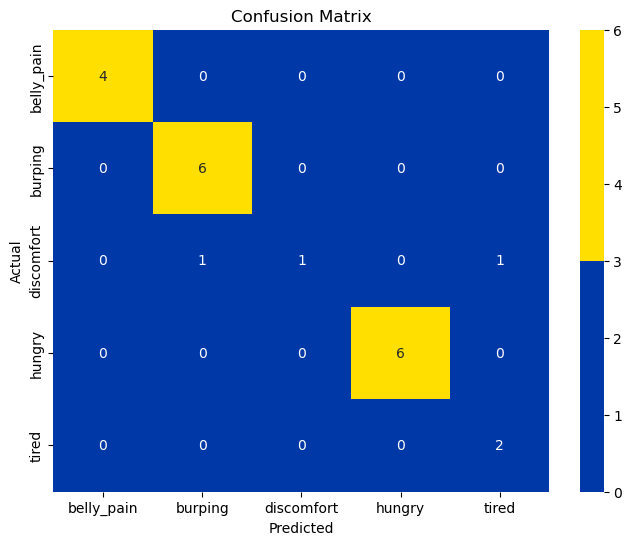

In [13]:
plt.figure(figsize=(8, 6))
yellow = (255 / 255, 223 / 255, 0 / 255)
blue = (0 / 255, 56 / 255, 168 / 255)
custom_cmap = sns.color_palette([blue, yellow])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=custom_cmap, xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# import pickle

# with open("Forest_5_98.pkl","wb") as file:
#     pickle.dump(forest_model, file)

In [15]:
import pickle
with open("Forest_model.pkl", "rb") as file:
    forest_model = pickle.load(file)

C:\Users\VIRAJ\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\VIRAJ\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
def predict(audio_features, model):
    features_flatten = audio_features.flatten()
    required_features = 1200
    repeat_times = required_features // len(features_flatten) + 1
    extended_features = np.tile(features_flatten, repeat_times)[:required_features]
    extended_features = np.expand_dims(extended_features, axis=0)  
    
    prediction = model.predict(extended_features)
    return prediction

In [17]:
class_labels = {
    0: "belly_pain",
    1: "burping",
    2: "discomfort",
    3: "hungry",
    4: "tired"
}

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
folder = 'data_5_class'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
for subfolder in os.listdir(folder):
    subfolder_path = os.path.join(folder, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing files in folder: {subfolder_path}") 
        for file_name in os.listdir(subfolder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(subfolder_path, file_name)
                
                mfcc_features = extract_mfcc(file_path)
                
                prediction_index = predict(mfcc_features, my_forest)
                
                prediction_label = class_labels.get(prediction_index[0])
                
                print(f"Predicted class for {file_name} is: {prediction_label}")


Processing files in folder: data_5_class\belly_pain
Predicted class for 549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav is: hungry
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp.wav is: hungry
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138536-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138545-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138647-1.0-m-72-bp.wav is: hungry
Predicted class for 69BDA5D6-0276-4462-9BF7-951799563728-143693618

Predicted class for D1CB71F9-EF76-49B3-A703-41D557444D21-1436863366-1.1-m-04-hu.wav is: hungry
Predicted class for D1CB71F9-EF76-49B3-A703-41D557444D21-1436863375-1.1-m-04-hu.wav is: hungry
Predicted class for d1e236a0-e030-4137-9030-5625026cd098-1430477951092-1.2-m-04-hu.wav is: hungry
Processing files in folder: data_5_class\tired
Predicted class for 03ADDCFB-354E-416D-BF32-260CF47F7060-1433658024-1.1-f-04-ti.wav is: tired
Predicted class for 06c4cfa2-7fa6-4fda-91a1-ea186a4acc64-1430029221058-1.7-f-26-ti.wav is: tired
Predicted class for 06c4cfa2-7fa6-4fda-91a1-ea186a4acc64-1430029237378-1.7-f-26-ti.wav is: hungry
Predicted class for 06c4cfa2-7fa6-4fda-91a1-ea186a4acc64-1430029246453-1.7-f-26-ti.wav is: hungry
Predicted class for 1309B82C-F146-46F0-A723-45345AFA6EA8-1430059864-1.0-f-04-ti.wav is: hungry
Predicted class for 1309B82C-F146-46F0-A723-45345AFA6EA8-1431172241-1.0-f-48-ti.wav is: tired
Predicted class for 5B416CE8-2591-4531-9ADC-86D085B5D48B-1430144827-1.0-m-48-ti.wav is: t

In [ ]:
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import time
import librosa
import noisereduce as nr
import os
import soundfile as sf

In [ ]:
# Function to record audio
def record_audio(filename, duration=7, sr=44100):
    chunk = 1024
    format = pyaudio.paInt16
    channels = 1
    p = pyaudio.PyAudio()
    
    print("Recording...")
    stream = p.open(format=format,
                    channels=channels,
                    rate=sr,
                    input=True,
                    frames_per_buffer=chunk)
    
    frames = []
    for i in range(0, int(sr / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)
    
    print("Finished recording.")
    
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(format))
    wf.setframerate(sr)
    wf.writeframes(b''.join(frames))
    wf.close()

# Function to clean audio
def clean_audio(audio_file_path):
    y, sr = librosa.load(audio_file_path, sr=None)
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
    return y_trimmed, sr

# Function to plot audio waveform
def plot_waveform(signal, sr):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(signal) / sr, num=len(signal)), signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Waveform')
    plt.show()

# Function to record, clean, plot waveform, and predict
def process_audio(filename):
    # Record audio
    record_audio(filename)
    
    # Clean audio
    cleaned_signal, sr = clean_audio(filename)
    
    # Plot waveform
    plot_waveform(cleaned_signal, sr)
    
    # Extract MFCC features and make prediction
    # Assuming you have the extract_mfcc and predict functions implemented
    mfcc_features = extract_mfcc(filename)
    prediction_index = predict(mfcc_features, forest_model)
    prediction_label = class_labels.get(prediction_index[0])

    print("Predicted class:", prediction_label)

# Record, clean, plot waveform, and predict audio
filename = 'recorded_audio.wav'
process_audio(filename)
